# Installing Libraries and Downloading CSV

In [1]:
# %pip install --upgrade pandas
# %pip install --upgrade nltk
# %pip install --upgrade contractions

In [2]:
import pandas as pd
from collections import Counter
import itertools 
import re
import contractions

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('treebank')
nltk.download('stopwords')

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/leomoore/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwor

True

In [3]:
df_a = pd.read_csv("fake_job_postings_A.csv")
df_b = pd.read_csv("fake_job_postings_B.csv")

df = pd.concat([df_a, df_b], ignore_index=True)

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Cleaning Dataframe

In [4]:
# It appears the tokenizing was already done for us, although the format is not very good for analysis
def textwash(col):
    df[col] = df[col].str.replace(r"http\w+", " url_token", regex=True) # urls
    df[col] = df[col].str.replace(r"https?://\w+", " url_token", regex=True) # urls
    df[col] = df[col].str.replace(r"#URL_\w+", " url_token", regex=True) # urls

    df[col] = df[col].str.replace(r"#EMAIL_\w+", " email_token", regex=True) # email

    df[col] = df[col].str.replace(r"$\d+", " money_token", regex=True) # money

    df[col] = df[col].str.replace("\xa0", " ") # Non-breaking space
    df[col] = df[col].str.replace("&amp", " ") # Ampersand

    df[col] = df[col].str.replace(r"[^\w\s]", " ", regex=True) # remove nonword characters generally
    df[col] = df[col].str.replace(r"\s{2,}", " ", regex=True) # reduce repeat spaces
    df[col] = df[col].str.lower()

In [5]:
# Tokenize urls, emails, and money, remove nonword characters
df = df[df['company_profile'].str.len() > 0]
df = df[df['description'].str.len() > 0]
df = df[df['requirements'].str.len() > 0]
df = df[df['benefits'].str.len() > 0]

textwash("company_profile")
textwash("description")
textwash("requirements")
textwash("benefits")

df["description"].head()

1    organised focused vibrant awesome do you have ...
3    the company esri environmental systems researc...
4    job title itemization review managerlocation f...
6    your responsibilities manage the english speak...
7    who is airenvy hey there we are seasoned entre...
Name: description, dtype: object

# EDA, Non-text Data Analysis, Topic Analysis

In [6]:
# Summary Statistics
import numpy as np
from scipy import stats

fraud_lens = [len(desc) for desc in df[df["fraudulent"] == 1]["description"] if not isinstance(desc, float)]
legit_lens = [len(desc) for desc in df[df["fraudulent"] == 0]["description"] if not isinstance(desc, float)]

x = stats.ttest_ind(fraud_lens, legit_lens, alternative='less')

print(f"Mean length of fraudulent description: {np.mean(fraud_lens)}\n\
      Mean length of legitimate description: {np.mean(legit_lens)}\n\
      P-value of one-sided t-test: {x.pvalue}")

Mean length of fraudulent description: 1290.5454545454545
      Mean length of legitimate description: 1128.8124131542381
      P-value of one-sided t-test: 0.9989249863427043


In [7]:
# Set parameters for stop words and min word length, to be used later

global_stopwords = nltk.corpus.stopwords.words("english")
THRESHOLD = 3

In [8]:
# Get list of words in the fraudulent descriptions

fraudulent_description = df[df["fraudulent"] == 1]["description"]

fraud_words = [nltk.word_tokenize(s) for s in fraudulent_description if isinstance(s, str)]
fraud_words = list(itertools.chain.from_iterable(fraud_words))
fraud_words = [w for w in fraud_words if len(w)> THRESHOLD and w not in global_stopwords]

fraud_words[0:5]

['technician', 'bakersfield', 'posoprincipal', 'duties', 'responsibilities']

In [9]:
# Get most common words in fraudulent descriptions

fraud_counts = Counter(fraud_words)
fraud_counts.most_common(20)
fraud_freq = pd.DataFrame(fraud_counts.most_common(), columns=["Fraud_Term", "Frequency"])

fraud_freq.head(10)

,Fraud_Term,Frequency
0,work,261
1,team,207
2,product,171
3,engineering,169
4,products,156
5,project,154
6,customer,141
7,position,141
8,equipment,137
9,provide,136


In [10]:
# Get list of words in the legitimate descriptions

legitimate_description = df[df["fraudulent"] == 0]["description"]

legit_words = [nltk.word_tokenize(s) for s in legitimate_description if isinstance(s, str)]
legit_words = list(itertools.chain.from_iterable(legit_words))
legit_words = [w for w in legit_words if len(w) > THRESHOLD and w not in global_stopwords]

legit_words[0:5]

['organised', 'focused', 'vibrant', 'awesome', 'passion']

In [11]:
# Get most common words in legitimate descriptions

legit_counts = Counter(legit_words)
legit_counts.most_common(20)
legit_freq = pd.DataFrame(legit_counts.most_common(), columns=["Legit_Term", "Frequency"])
legit_freq.head(10)

,Legit_Term,Frequency
0,team,9308
1,work,6871
2,sales,5621
3,company,5595
4,business,5426
5,looking,4715
6,customer,4218
7,marketing,4059
8,product,3962
9,development,3883


# Sentiment Analysis

In [12]:
%pip install textblob nltk
%pip install nltk #ensuring nltk installation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 5.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import nltk
nltk.download('vader_lexicon')  # VADER lexicon download/reinstall

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leomoore/nltk_data...


True

In [14]:
%pip install pandas

import pandas as pd

df_a = pd.read_csv("fake_job_postings_A.csv")
df_b = pd.read_csv("fake_job_postings_B.csv")
df_combined = pd.concat([df_a, df_b], ignore_index=True)  # New variable name to avoid overwriting 'df'

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Sentiment Analysis 
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download required resources
nltk.download('vader_lexicon')

# TextBlob sentiment polarity (range: -1 to 1)
def textblob_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df['textblob_sentiment'] = df['description'].apply(textblob_sentiment)

# VADER compound score (range: -1 to 1)
sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return sid.polarity_scores(str(text))['compound']

df['vader_sentiment'] = df['description'].apply(vader_sentiment)

# Optional: Convert VADER score into labels
def label_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_label'] = df['vader_sentiment'].apply(label_sentiment)

# View results
df[['description', 'textblob_sentiment', 'vader_sentiment', 'vader_label']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,description,textblob_sentiment,vader_sentiment,vader_label
1,organised focused vibrant awesome do you have ...,0.277178,0.9954,Positive
3,the company esri environmental systems researc...,0.221875,0.9968,Positive
4,job title itemization review managerlocation f...,0.126033,0.9559,Positive
6,your responsibilities manage the english speak...,0.415000,0.8360,Positive
7,who is airenvy hey there we are seasoned entre...,0.252449,0.9979,Positive


In [16]:
# Installing 'seaborn' for visualization
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


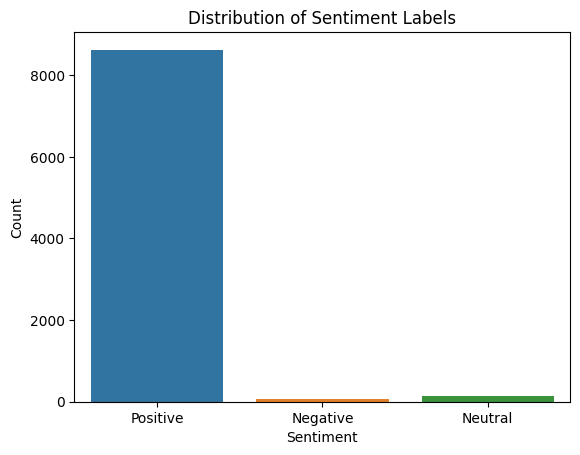

In [17]:
# Visualization of Sentiment Analysis (Optional to Keep)...also lets us visualize and see next steps if needed for the project
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='vader_label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Readibility Analysis

In [18]:
# Installing packages
%pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import textstat

df['readability_fk'] = df['description'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
df['readability_fre'] = df['description'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df['readability_gfi'] = df['description'].apply(lambda x: textstat.gunning_fog(str(x)))

In [20]:
# Results preview
df[['description', 'readability_fk', 'readability_fre', 'readability_gfi']].head()

,description,readability_fk,readability_fre,readability_gfi
1,organised focused vibrant awesome do you have ...,129.7,-262.81,133.38
3,the company esri environmental systems researc...,147.6,-331.16,151.80
4,job title itemization review managerlocation f...,81.4,-169.44,83.22
6,your responsibilities manage the english speak...,27.9,2.12,30.00
7,who is airenvy hey there we are seasoned entre...,162.4,-342.65,168.40


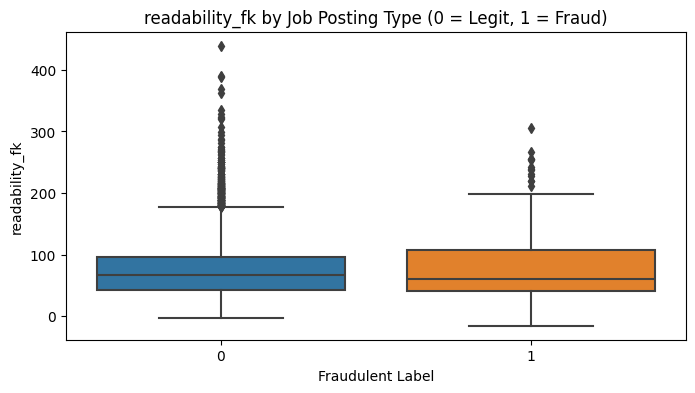

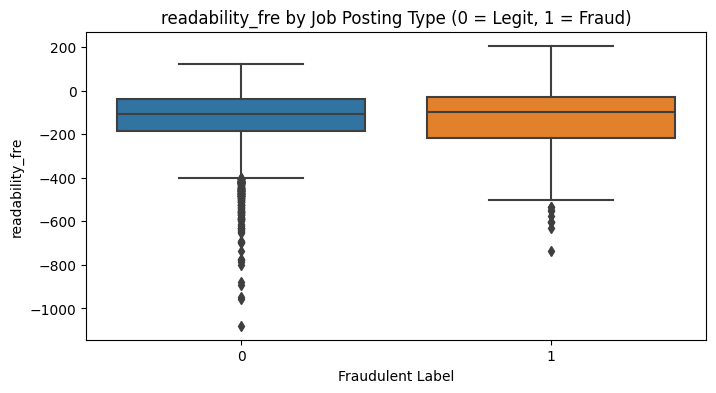

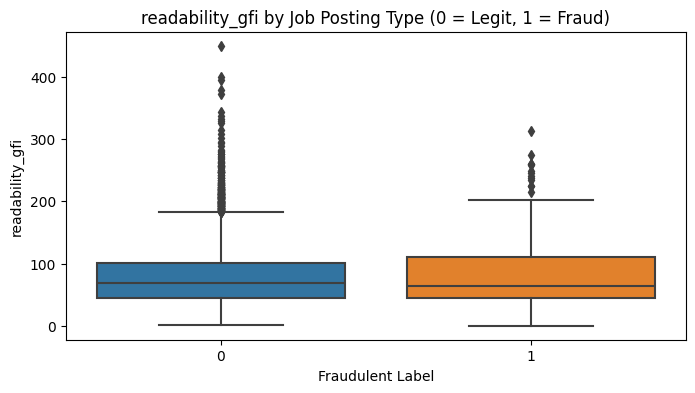

In [21]:
# Comparing readability scores between real vs faux job postings
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
readability_metrics = ['readability_fk', 'readability_fre', 'readability_gfi']

for metric in readability_metrics:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='fraudulent', y=metric, data=df)
    plt.title(f'{metric} by Job Posting Type (0 = Legit, 1 = Fraud)')
    plt.xlabel('Fraudulent Label')
    plt.ylabel(metric)
    plt.show()

In [22]:
# Summary Statistics
df.groupby('fraudulent')[['readability_fk', 'readability_fre', 'readability_gfi']].mean()

,readability_fk,readability_fre,readability_gfi
fraudulent,,,
0,73.864428,-123.490692,76.979412
1,81.267464,-149.611148,84.434450


# Logistic Regression

In [23]:
# %pip install --upgrade scikit-learn
# %pip install --upgrade scipy

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [25]:
# Create vectorizer
vectorizer = CountVectorizer(stop_words=global_stopwords, ngram_range=(2,2))

In [26]:
# Create train and test dfs
df_train, df_test = train_test_split(df, test_size=0.3, random_state=2021)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


# Create the training DTM and the labels
train_x = vectorizer.fit_transform([desc for desc in df_train['description'] if not isinstance(desc, float)])
train_y = df_train["fraudulent"]

test_x = vectorizer.transform([desc for desc in df_test['description'] if not isinstance(desc, float)])
test_y = df_test["fraudulent"]

# Check your answer
print(train_x.shape)
print(test_x.shape)

(6191, 270692)
(2654, 270692)


In [27]:
# Run model
sparselr = LogisticRegression(penalty='l1',
                              solver='liblinear',
                              random_state=2021,
                              tol=0.001,
                              max_iter=1000,
                              C=100)
sparselr.fit(train_x, train_y)

print(sum(sparselr.coef_[0]!=0))

1789


In [28]:
# Get model train and test accuracy
print("Train:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:,1]))
print("Test:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:,1]))

Train:
0.9999994754588162
Test:
0.9553042115809058


In [29]:
# Words that most indicate a scam
dfbeta = pd.DataFrame({"Term": vectorizer.get_feature_names_out(),
                       "Beta": sparselr.coef_[0]})
dfbeta.sort_values(by="Beta", inplace=True, ascending=True)
dfbeta.reset_index(inplace=True, drop=True)
dfbeta.head(10)

,Term,Beta
0,end users,-3.097188
1,job title,-2.800273
2,play kids,-2.628781
3,help us,-2.523745
4,join team,-2.452053
5,design develop,-2.414085
6,related duties,-2.359132
7,project manager,-2.307218
8,business process,-2.257536
9,main duties,-2.252502


# Topic Modelling

In [37]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

import nltk
nltk.download("stopwords")
global_stopwords = nltk.corpus.stopwords.words("english")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
vectorizer = CountVectorizer(stop_words=global_stopwords, max_features=100)

train_x = vectorizer.fit_transform(df_train["description"])
test_x = vectorizer.transform(df_test["description"])
print(train_x.shape)
print(test_x.shape)

(5926, 100)
(2919, 100)


In [49]:
lda = LatentDirichletAllocation(n_jobs=-1, random_state=2021)
num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
perplexity = []
for i in num_topics:
  print('next')
  lda.set_params(n_components=i)
  lda.fit(train_x)
  perplexity.append(lda.perplexity(test_x))

next
next
next
next
next
next
next
next
next
next
next
next
next
next


8


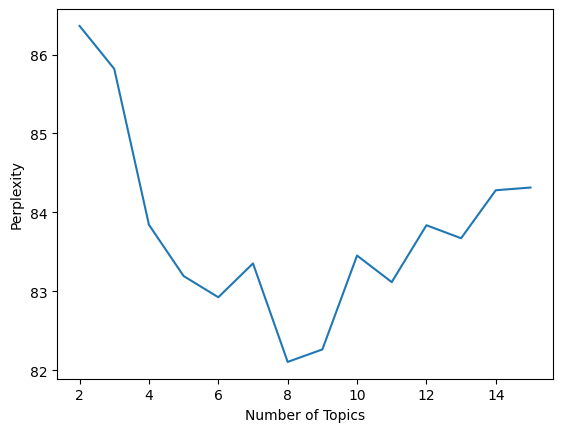

In [ ]:
import matplotlib.pyplot as plt
plt.plot(num_topics, perplexity)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")

In [56]:
DTM = vectorizer.fit_transform(df["description"])
lda = LatentDirichletAllocation(n_components=np.argmin(perplexity)+2, n_jobs=-1, random_state=2021)
lda.fit(DTM)

LatentDirichletAllocation(n_components=8, n_jobs=-1, random_state=2021)

In [57]:
from sklearn import preprocessing

temparray = preprocessing.normalize(lda.components_, norm="l1")
TTopicM = pd.DataFrame(np.transpose(temparray), index=vectorizer.get_feature_names_out())
TermOfTopic = pd.DataFrame([])
for i in range(TTopicM.shape[1]):
  TermOfTopic[i] = (list(TTopicM.sort_values(by=i, ascending=False).iloc[:10, i].index))
TermOfTopic

,0,1,2,3,4,5,6,7
0,work,team,sales,url_token,client,company,business,marketing
1,job,product,customer,get,account,team,data,digital
2,service,work,customers,love,media,management,sales,design
3,project,looking,product,apply,social,work,role,media
4,time,development,service,systems,clients,support,opportunity,user
5,customer,new,services,us,team,services,looking,team
6,provide,software,products,technical,management,office,clients,new
7,position,design,new,software,opportunities,development,team,web
8,experience,web,marketing,people,business,position,position,experience
9,projects,help,market,looking,manage,including,work,social


#  Word Embedding

In [30]:
!pip3 install --upgrade gensim
!pip3 install --upgrade python-Levenshtein

In [31]:
import numpy as np
import gensim.downloader as api
import pandas as pd
import re
import nltk
nltk.download("stopwords")
nltk.download("punkt_tab")
from sklearn.model_selection import train_test_split
from sklearn.svm import l1_min_c
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/leomoore/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [32]:
wv_300 = api.load("word2vec-google-news-300")

In [33]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

nltk_stopwords = nltk.corpus.stopwords.words("english")

len(df_train)

5926

In [66]:
train_x = np.empty((len(df_train), 300))  
for i in range(0, len(df_train)):         
  doc = df_train["description"][i]
  doc = doc.lower()                      
  doc = re.sub("[^\w\s]", " ", doc)       
  tokens = nltk.word_tokenize(doc)       
  tokens = [s for s in tokens if s not in nltk_stopwords]    
  tokens = [s for s in tokens if s in wv_300] 
  if tokens:
    vec = wv_300[tokens].mean(0)
    train_x[i] = vec                        

test_x = np.empty((len(df_test), 300))  
for i in range(0, len(df_test)):         
  doc = df_test["description"][i]
  doc = doc.lower()                      
  doc = re.sub("[^\w\s]", " ", doc)      
  tokens = nltk.word_tokenize(doc)        
  tokens = [s for s in tokens if s not in nltk_stopwords]    
  tokens = [s for s in tokens if s in wv_300] 
  if tokens: 
    vec = wv_300[tokens].mean(0)         
    test_x[i] = vec                        

train_y = df_train["fraudulent"]
test_y = df_test["fraudulent"]

In [67]:
param_grid = l1_min_c(train_x, train_y, loss='log') * np.logspace(start=0, stop=5, num=20)

sparselr = LogisticRegressionCV(penalty='l1',
                                 solver='liblinear',
                                 Cs=param_grid,
                                 cv=5,
                                 scoring='accuracy',
                                 random_state=2021,
                                 tol=0.001,
                                 max_iter=1000)
sparselr.fit(train_x, train_y)


LogisticRegressionCV(Cs=array([3.55366027e-04, 6.51379073e-04, 1.19396528e-03, 2.18851532e-03,
       4.01150637e-03, 7.35301379e-03, 1.34779324e-02, 2.47047902e-02,
       4.52834039e-02, 8.30036059e-02, 1.52144008e-01, 2.78877033e-01,
       5.11176222e-01, 9.36976154e-01, 1.71745922e+00, 3.14806962e+00,
       5.77035089e+00, 1.05769419e+01, 1.93873304e+01, 3.55366027e+01]),
                     cv=5, max_iter=1000, penalty='l1', random_state=2021,
                     scoring='accuracy', solver='liblinear', tol=0.001)

In [68]:
print("Train:")
print(accuracy_score(train_y, sparselr.predict(train_x)))
print("Test:")
print(accuracy_score(test_y, sparselr.predict(test_x)))
print("Train:")
print(roc_auc_score(train_y, sparselr.predict_proba(train_x)[:, 1]))
print("Test:")
print(roc_auc_score(test_y, sparselr.predict_proba(test_x)[:, 1]))

Train:
0.9861626729665879
Test:
0.9842411784857829
Train:
0.9773610464082865
Test:
0.9176052232715401
